# Project: Cleaning and Visualizing Data (SAT results)

## Questions to address:
- First data needs to be cleaned. There are 8 files that need to be processed and after that combined into a single dataset.
- Find which variables better correlate with SAT scores:
  - etnic origin
  - gender
  - percentage of students taking exams
- look at the geographical distribution of SAT score in NY

## Tools:
- data cleaning: 
  - pd.to_numeric(Series, errors="coerce")
  - Series.apply(function)
  - string operations: split, replace
  - df.groupby("col").agg(function)
  - merge dataframes: df.merge(df2, on="col", how="left/inner")
- bar plot
- sort two lists
- basemap toolkit: plot values on the map color coded by a 3rd variable

<br>

### load defaults

In [4]:
import pandas as pd
import re
import numpy as np

from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green']

<br>

## Dataset: SAT results in US schools

The dataset consists of 8 files that need to be cleaned and combined:
 - ap_2010.csv - Data on AP test results
 - class_size.csv - Data on class size
 - demographics.csv - Data on demographics
 - graduation.csv - Data on graduation outcomes
 - hs_directory.csv - A directory of high schools
 - sat_results.csv - Data on SAT scores
 - survey_all.txt - Data on surveys from all schools
 - survey_d75.txt - Data on surveys from New York City district 75
  
all files will be loaded into a single dictionary: data{}
 -  survey_all.txt and survey_d75.txt will be combined into survey

In [34]:
data_files = ["ap_2010.csv", "class_size.csv", "demographics.csv", 
              "graduation.csv", "hs_directory.csv", "sat_results.csv"]

data = {}

for f in data_files:
    d = pd.read_csv("./data/schools/{0}".format(f))
    data[f.replace(".csv", "")] = d
    
all_survey = pd.read_csv("data/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("data/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=True)

survey["DBN"] = survey["dbn"]

survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", 
                 "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", 
                 "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", 
                 "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

data_sets = ["ap_2010", "class_size", "demographics", "graduation", "hs_directory", "sat_results", "survey"]

print("reading done")

reading done


<b>DF snipet:</b>

In [35]:
for df in data_sets:    
    display(data[df].iloc[:3,:5])

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39,49,10
1,01M450,EAST SIDE COMMUNITY HS,19,21,s
2,01M515,LOWER EASTSIDE PREP,24,26,24


,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE
0,1,M,M015,P.S. 015 Roberto Clemente,0K
1,1,M,M015,P.S. 015 Roberto Clemente,0K
2,1,M,M015,P.S. 015 Roberto Clemente,01


,DBN,Name,schoolyear,fl_percent,frl_percent
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN


,Demographic,DBN,School Name,Cohort,Total Cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64


,dbn,school_name,borough,building_code,phone_number
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402


,DBN,rr_s,rr_t,rr_p,N_s
0,01M015,NaN,88,60,NaN
1,01M019,NaN,100,60,NaN
2,01M020,NaN,88,73,NaN


<br>

## Data Cleaning:

### Add DBN columns
'hs_directory' and 'class_size' don't have DBN columns
- 'hs_directory' has a dbn column
- 'class_size' has CSD and SCHOOL CODE that need to be combined

In [36]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

print("DBN columns added")

DBN columns added


<br>

### Convert columns to numeric
'sat_results', 'ap_2010' and 'hs_directory' data needs to be converted to numeric (errors="coerce" will return NaN for problematic values)
- 'sat_results': avg scores in math, reading and writing need to be converted and combined into sat_score 
- ap_2010: 3 columns converted to numeric
- 'hs_directory': lat and lon need to be extracted from Location 1 and converted to numeric 

In [37]:
#sat_results
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


#ap_2010
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")


#hs_directory    
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")



print("conversion to numeric done")

conversion to numeric done


<br>

### Condense datasets
- 'class_size':
  - will only contain GRADE 9-12 and GEN ED
  - CORE SUBJECTS will be aggregated
- 'demographics': select only the most recent school year (20112012)
- 'graduation': Demographic and Cohort are non unique
  - Cohort refers to the year, select most recent: 2006
  - Demographic refer to a demographic group, select: Total Cohort.

In [38]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#aggregrate the CORE SUBJECTS (mean of strings with same name) and return the mean of all other columns
class_size = class_size.groupby("DBN").agg(np.mean)
#Reset the index to make DBN a column again.
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

print("data sets condensed")

data sets condensed


<br>

### Combine the datasets
combine all files:
- left merge on 'sat_results', 'ap_2010' and 'graduation'
  - only use columns that exist on the dataframe on the "left" of the merge.
- plus inner merge on 'class_size', 'demographics', 'survey', 'hs_directory'
  - only combine rows for columns that exist in both data sets.

In [93]:
#Both the ap_2010 and the graduation data sets have many missing DBN values, 
#so we'll use a left join when we merge the sat_results data set with them.
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

#Because these files contain information that's more valuable to our analysis and 
#also have fewer missing DBN values, we'll use the inner join type.

to_merge = ["class_size", "demographics", "survey", "hs_directory"]
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

print("datasets combined")

datasets combined


<br>

### Add a school district column for mapping

In [94]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

<br>

## Analysis:


### Q1: Find the variables high highest correlation with SAT scores

In [130]:
correlations = combined.corr()
correlations = correlations["sat_score"]

#remove low correlations and variables with the SAT score that have very high correlation
print(correlations[((correlations>0.4) | (correlations<-0.4)) & (correlations<0.97)])

AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
frl_percent                            -0.722225
sped_percent                           -0.448170
asian_num                               0.475445
asian_per                               0.570730
white_num                               0.449559
white_per                               0.620718
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
Name: sat_score, dtype: float64


<br>

### Q2: Plot the correlations between different variables and SAT scores

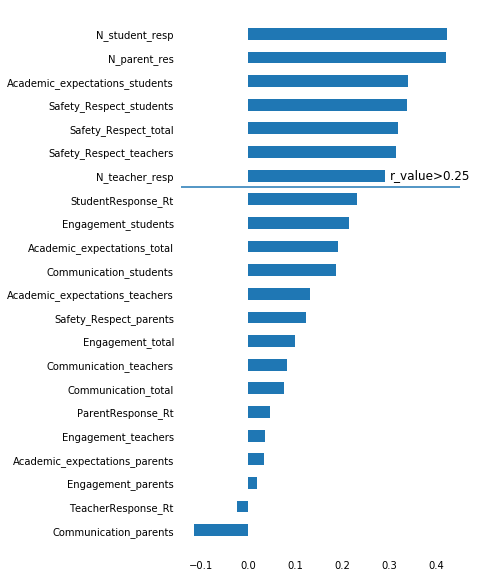

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

fig, ax = plt.subplots(figsize=(5,10))

field_names = ["rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", 
               "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", 
               "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", 
               "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", 
               "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

fields = ['StudentResponse_Rt', 'TeacherResponse_Rt', 'ParentResponse_Rt',
          'N_student_resp', 'N_teacher_resp', 'N_parent_res',
          'Safety_Respect_parents', 'Communication_parents',
          'Engagement_parents','Academic_expectations_parents',
          'Safety_Respect_teachers','Communication_teachers',
          'Engagement_teachers','Academic_expectations_teachers',
          'Safety_Respect_students','Communication_students',
          'Engagement_students','Academic_expectations_students',
          'Safety_Respect_total','Communication_total',
          'Engagement_total','Academic_expectations_total']


bar_pos = np.arange(0,len(fields),1.) + 1.
bar_widths = correlations[field_names]

#sort fields according to bar_widths
combined_list = sorted(zip(bar_widths, fields))
fields = [x for y, x in combined_list]
bar_widths = sorted(bar_widths)

ax.barh(bar_pos, bar_widths, height=0.5)

ax.set_ylim(0,len(fields)+1)
ax.set_yticks(bar_pos)
ax.set_yticklabels(fields)
for key,spine in ax.spines.items():
        spine.set_visible(False)
ax.tick_params(left=False, right=False, top=False, bottom=False)
ax.axhline(15.5)
ax.text(0.75, 0.69, 'r_value>0.25', fontsize=12, transform=ax.transAxes)
plt.show()

<br>

### Q3: Look at the correlation between the Safety Respect as seen by the students and SAT scores

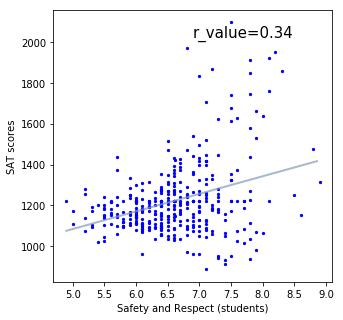

In [113]:
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(combined['saf_s_11'], combined['sat_score'], s=5, color='blue')
ax.set_xlabel('Safety and Respect (students)')
ax.set_ylabel('SAT scores')

slope,intercept,r_value,p_value,stderr_slope = linregress(combined['saf_s_11'], combined['sat_score'])
xx = np.arange(min(combined['saf_s_11']), max(combined['saf_s_11']), (max(combined['saf_s_11'])-min(combined['saf_s_11']))/100.)
ax.plot(xx,xx*slope+intercept, color="#849AB8", linewidth=2, alpha=0.7)
ax.text(0.5, 0.9, 'r_value=%0.2f' % (r_value), fontsize=15, transform=ax.transAxes)

plt.show()

<br>

### Q4: group by school district and plot values on a map

This will allows us to look at the geographical distribution of SAT scores and english learning percentage. We can test the hipotesis that students learning english will likely be in immigrant communities with lower socio-economic backgrounds and have lower SAT scores

In [117]:
groups = combined.groupby(combined['school_dist'])
districts = groups.agg(np.mean)
districts.reset_index(inplace=True)


### Look at SAT results value per geographical location in NY

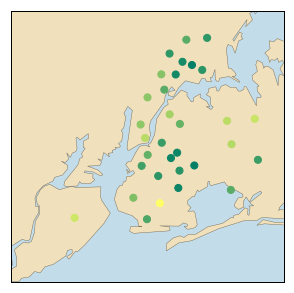

In [124]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(5,5))
m = Basemap(projection='merc', llcrnrlat=40.496044, urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, urcrnrlon=-73.700272, resolution='h')
m.fillcontinents(color='#F0E0BB', lake_color='#BBDDF0')
m.drawmapboundary(fill_color='#C2DCEA')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
#zorder - 2 draws the points on top of the continents, which is where we want them.
#latlon - latitude and longitude coordinates instead of x and y plot coordinates.
#c - color code by another variable automatically converted to values ranging from 0 to 1. 
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts['sat_score'], cmap='summer')
plt.show()

### Look at the percentage of students learning english per geographical location in NY

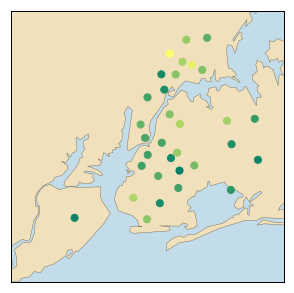

In [125]:
fig = plt.figure(figsize=(5,5))

m = Basemap(projection='merc', llcrnrlat=40.496044, urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, urcrnrlon=-73.700272, resolution='h')
m.fillcontinents(color='#F0E0BB', lake_color='#BBDDF0')
m.drawmapboundary(fill_color='#C2DCEA')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts['ell_percent'], cmap='summer')

plt.show()

- it's hard to see a clear pattern from the plot (although the correlation coefficient between the 2 varaibles is ~-0.4)

<br>

### Q5: Look at the correlation between SAT scores and etnic origin

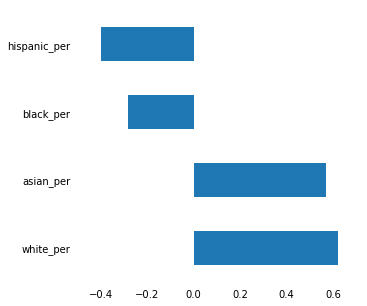

In [138]:
fig, ax = plt.subplots(figsize=(5,5))

field_names = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
bar_widths = correlations[field_names]
bar_pos = np.arange(0,len(field_names),1.0)+1.
ax.barh(bar_pos, bar_widths, height=0.5)

ax.set_ylim(0+0.5, (len(field_names)+1)-0.5)
ax.set_xlim(-0.5, 0.7)
ax.set_yticks(bar_pos)
ax.set_yticklabels(field_names)

for key,spine in ax.spines.items():    
    spine.set_visible(False)
ax.tick_params(left=False, right=False, top=False, bottom=False)

- Hispanics seem to performe horse. Strong correlation between Asian and White percentage

### Zoom in on hispanic percentange

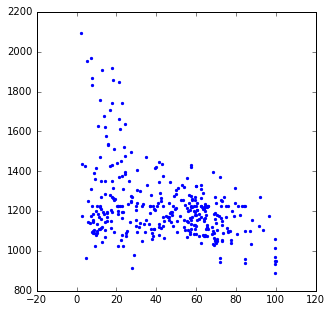

In [73]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(combined['hispanic_per'], combined['sat_score'], s=5, color='blue')

The correlation between hispanic_per and sat_score isnt obvious. It seems to be driven by <b>very high scores at low hispanic percentages</b> and <b>very low scores at 100% hispanic</b>

### Find the names of these extreme cases driving the correlation

In [79]:
print(combined[combined['hispanic_per']>95][['SCHOOL NAME','sat_score']])

                                           SCHOOL NAME  sat_score
44                       MANHATTAN BRIDGES HIGH SCHOOL     1058.0
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL     1174.0
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...     1014.0
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY      951.0
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS      934.0
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE      970.0
253                          MULTICULTURAL HIGH SCHOOL      887.0
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL      951.0


In [82]:
print(combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)][['SCHOOL NAME']])

                                           SCHOOL NAME
37                              STUYVESANT HIGH SCHOOL
151                       BRONX HIGH SCHOOL OF SCIENCE
187                     BROOKLYN TECHNICAL HIGH SCHOOL
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                STATEN ISLAND TECHNICAL HIGH SCHOOL


- All schools with low hispanic percentage and high SAT scores are elite, highly selective schools

<br>

### Q6: Correlation between SAT scores and gender

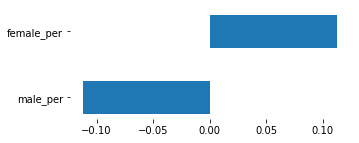

In [148]:
fig, ax = plt.subplots(figsize=(5,2))

field_names=['male_per', 'female_per']
bar_widths=correlations[field_names]
bar_pos=np.arange(0,len(field_names),1)-0.5
ax.barh(bar_pos, bar_widths, height=0.5)

ax.set_yticks(bar_pos)
ax.set_yticklabels(field_names)
for key,spine in ax.spines.items():
        spine.set_visible(False)
ax.tick_params(right=False, top=False)
        
plt.show()

- Males percentage inversely correlated with SAT scores: males perform significantly worse

### Zoom in on female percentage

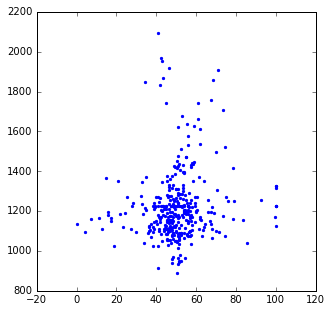

In [98]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(combined['female_per'], combined['sat_score'], s=5, color='blue')
plt.show()

- Schools with 100% female perform average. 

- between 50% and 80% there are some schools with very high SAT scores
  - this hints at an hidden variable that causes these schools to form a separate relation

- highest achievers are schools with ~50/50 (or 40% female)

### Zoom in on schools with high female percentage and high SAT scores

In [99]:
sel = (combined['female_per']>60) & (combined['sat_score']>1700)
print(combined[sel]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


- all very selective schools

<br>

### Q7: Correlation between percentage of students taking exams and SAT scores

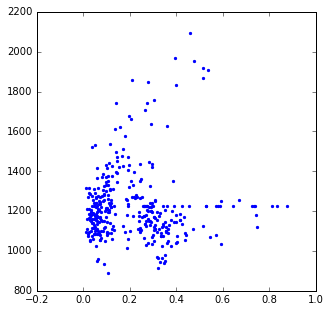

In [100]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(combined['ap_per'], combined['sat_score'], s=5, color='blue')
plt.show()

- There is a strong correlations between 20 and 60%, flat and low above 60

### Zoom in on schools with high percentage of exam takes and low sat scores

In [104]:
sel = (combined['ap_per']>0.7)
print(combined[sel]['SCHOOL NAME'])

6      47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...
31                 MANHATTAN ACADEMY FOR ARTS & LANGUAGE
33             INTERNATIONAL HIGH SCHOOL AT UNION SQUARE
83             HIGH SCHOOL FOR EXCELLENCE AND INNOVATION
111                            BRONX BRIDGES HIGH SCHOOL
208                              FRANCES PERKINS ACADEMY
222               THE BROOKLYN ACADEMY OF GLOBAL FINANCE
335                              CAMBRIA HEIGHTS ACADEMY
Name: SCHOOL NAME, dtype: object


- these are schools with particular characteristics (e.g. recently arrived immigrants or students with learning difficulties  )

<br>
<br>
potential next steps:

- Determing wheter there's a correlation between class size and SAT scores
- Figuring out which neighborhoods have the best schools
- If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
- Investigating the differences between parent, teacher, and student responses to surveys.
- Assigning scores to schools based on sat_score and other attributes.